In [54]:
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model,load_model
from keras.applications.mobilenet import preprocess_input
from keras.applications import MobileNet
from keras.preprocessing import image



In [12]:
data_path = "c:\\Lori\\Suil\\DA_3\\Hazi_2\\HDNHD\\hot-dog-not-hot-dog"
batch_size = 32

**Creating the image data generators for data augmentation**

For the augmentation process I rescaled, sheared, zoomed and fliped the pictures.

In [13]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
        data_path+'/train',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
    data_path+'/train',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 400 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [16]:
test_generator = test_datagen.flow_from_directory(
        data_path+'/test',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 500 images belonging to 2 classes.


#### Taking a look at some of the augmented pictures ####

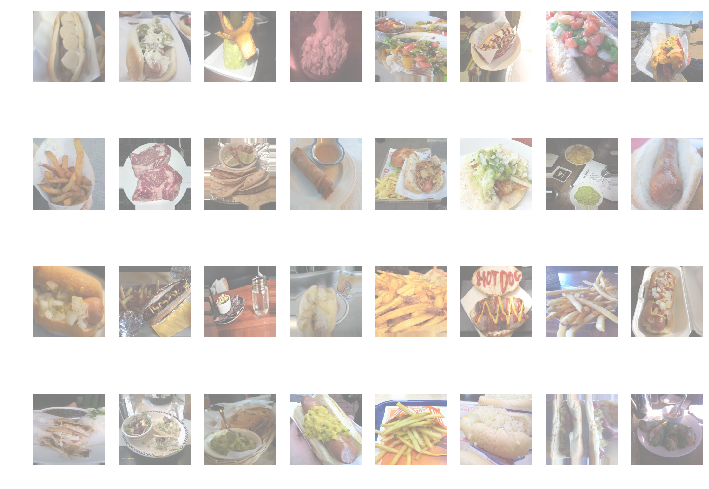

In [17]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

**Building a basic model** 

First I built a very basic model to see how accurate it can guess the hot-dogs and non hot-dogs. The model has 4 convolutional layers, 2 pooling layers and 3 dense layers. I also added 4 dropout layers to avoid overfitting. 

For activation functions I used relu and I used adam optimizer. For the metric of the model I set accuracy, for the loss function I used categorical crossentropy.

In [20]:
train_steps = train_generator.n // train_generator.batch_size
valid_steps = validation_generator.n // validation_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

In [21]:
CLASSES=2

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASSES,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 299, 299, 32)      896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 99, 99, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 99, 99, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 64)        0         
__________

In [22]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch= train_steps,
        validation_data=validation_generator,
        validation_steps = valid_steps,
        epochs=10)

Epoch 1/10
12/12 [==============================] - 116s 10s/step - loss: 1.4912 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.5521
Epoch 2/10
12/12 [==============================] - 116s 10s/step - loss: 0.6942 - acc: 0.5312 - val_loss: 0.6935 - val_acc: 0.4697
Epoch 3/10
12/12 [==============================] - 106s 9s/step - loss: 0.6932 - acc: 0.5131 - val_loss: 0.6938 - val_acc: 0.4545
Epoch 4/10
12/12 [==============================] - 113s 9s/step - loss: 0.6926 - acc: 0.5388 - val_loss: 0.6922 - val_acc: 0.5758
Epoch 5/10
12/12 [==============================] - 110s 9s/step - loss: 0.6930 - acc: 0.5131 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/10
12/12 [==============================] - 109s 9s/step - loss: 0.6935 - acc: 0.4761 - val_loss: 0.6930 - val_acc: 0.5303
Epoch 7/10
12/12 [==============================] - 108s 9s/step - loss: 0.6934 - acc: 0.4815 - val_loss: 0.6934 - val_acc: 0.3939
Epoch 8/10
12/12 [==============================] - 109s 9s/step - loss: 0.6930 -

In [ ]:
As we can see 

Saving the model

In [11]:
model.save("hot_dog_basic.h5py")

### Transfer learning with Inception v3 model ###

For transfer learning I used the Inception model. For the weights I used "imagenet" weights. At the end of the inception model I have added my own layers (which are trained): a pooling layer a dropout layer and a dense layer. 

As my computer is limited in terms of computing capacity I did not choose to train the inception layers (however I included in the code the method for it but I left it commented out) and I only choose 5 epochs and a batch size of 64.

In [24]:
    
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# basic transfer learning - I do not train the model at all
for layer in base_model.layers:
    layer.trainable = False
    
    
# more advanced transfer learning - I train the last 20 layers of the model, leaving the first 20 layers untouched.
#for layer in model.layers[:20]:
#    layer.trainable = False    
#    
#for layer in model.layers[20:]:
#    layer.trainable = True     

      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
EPOCHS = 5
BATCH_SIZE = 64
STEPS_PER_EPOCH = 256
VALIDATION_STEPS = 64

history = model.fit_generator(
        train_generator,
        steps_per_epoch= train_steps,
        validation_data=validation_generator,
        validation_steps = valid_steps,
        epochs=10)


Epoch 1/10
12/12 [==============================] - 110s 9s/step - loss: 0.7991 - acc: 0.5884 - val_loss: 0.5770 - val_acc: 0.8182
Epoch 2/10
12/12 [==============================] - 110s 9s/step - loss: 0.6583 - acc: 0.6298 - val_loss: 0.6719 - val_acc: 0.5521
Epoch 3/10
12/12 [==============================] - 105s 9s/step - loss: 0.5899 - acc: 0.6849 - val_loss: 0.3833 - val_acc: 0.9091
Epoch 4/10
12/12 [==============================] - 102s 8s/step - loss: 0.5053 - acc: 0.7448 - val_loss: 0.4047 - val_acc: 0.8485
Epoch 5/10
12/12 [==============================] - 101s 8s/step - loss: 0.4762 - acc: 0.7580 - val_loss: 0.2912 - val_acc: 0.9091
Epoch 6/10
12/12 [==============================] - 110s 9s/step - loss: 0.4605 - acc: 0.7781 - val_loss: 0.3942 - val_acc: 0.8438
Epoch 7/10
12/12 [==============================] - 101s 8s/step - loss: 0.4478 - acc: 0.7966 - val_loss: 0.4704 - val_acc: 0.7273
Epoch 8/10
12/12 [==============================] - 103s 9s/step - loss: 0.4240 - a

Saving the model

In [26]:
model.save("own_inception_model.model")

In order to visualize the model I have created a plotting function which plost the training/validation losses and accuracies. As we can see the validation accuracy of the model is around 91%.

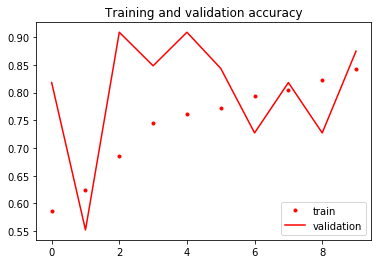

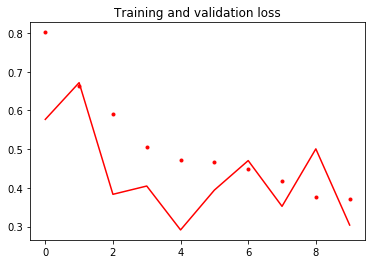

In [31]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.',label='train')
  plt.plot(epochs, val_acc, 'r',label='validation')
  plt.title('Training and validation accuracy')
  plt.legend()
  
  plt.figure()
  plt.plot(epochs, loss, 'r.',label='train')
  plt.plot(epochs, val_loss, 'r-',label='validation')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

### Testing the model ###

In order to see how the model works I have created a function which shows the chosen picture and also shows the prediction probabilities given by the model.

In [59]:
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [64]:
def plot_preds(img, preds):
    labels = ("hot-dog", "NOT hot-dog")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probabilty')
    plt.xlim(0, 1)
    plt.tight_layout()

In [35]:

model = load_model("own_inception_model.model")

Let's first try the model on hot dog pictures.

array([0.94207627, 0.05792376], dtype=float32)

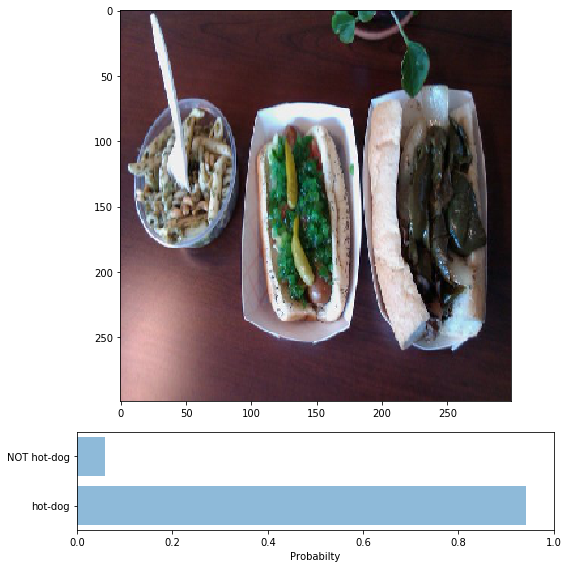

In [77]:
fnames = os.listdir('test/hot_dog')
sel_fname = fnames[1]
img = image.load_img('test/hot_dog/'+sel_fname, target_size=(299, 299))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)
preds

array([0.98812217, 0.01187778], dtype=float32)

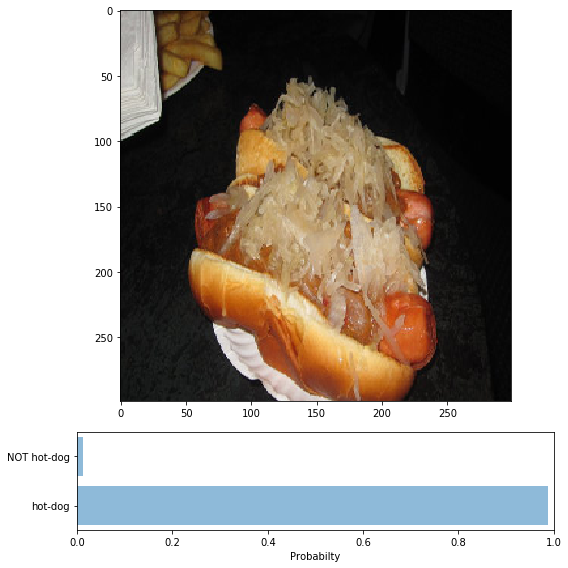

In [78]:
fnames = os.listdir('test/hot_dog')
sel_fname = fnames[42]
img = image.load_img('test/hot_dog/'+sel_fname, target_size=(299, 299))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)
preds

array([0.87542975, 0.12457017], dtype=float32)

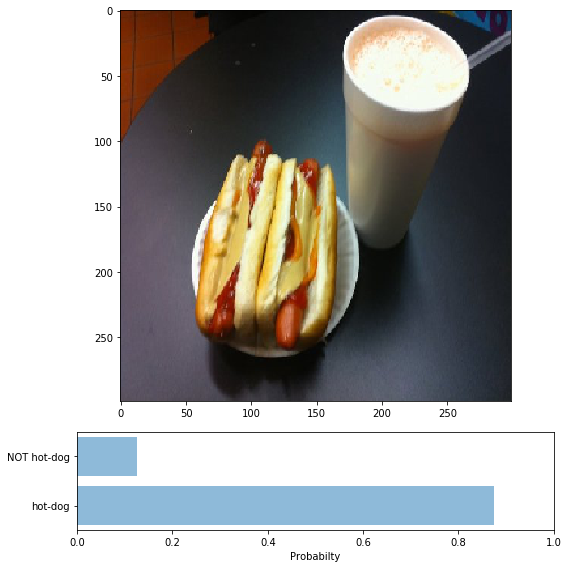

In [79]:
fnames = os.listdir('test/hot_dog')
sel_fname = fnames[8]
img = image.load_img('test/hot_dog/'+sel_fname, target_size=(299, 299))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)
preds

It seems that the model is quite good in guessing the hot dogs.

Now let's see how it performs when non hot dogs are shown.

array([0.29429063, 0.7057094 ], dtype=float32)

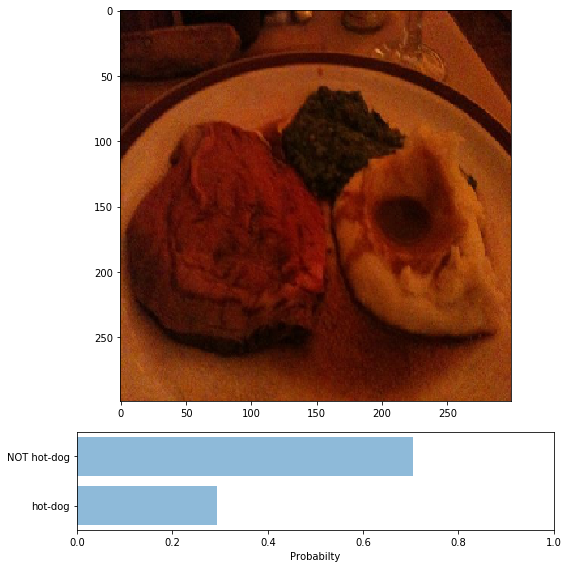

In [80]:
os.chdir("c:\\Lori\\Suil\\DA_3\\Hazi_2\\HDNHD\\hot-dog-not-hot-dog")

fnames = os.listdir('test/not_hot_dog')
sel_fname = fnames[8] #123
img = image.load_img('test/not_hot_dog/'+sel_fname, target_size=(299, 299))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)
preds



array([0.67133915, 0.3286609 ], dtype=float32)

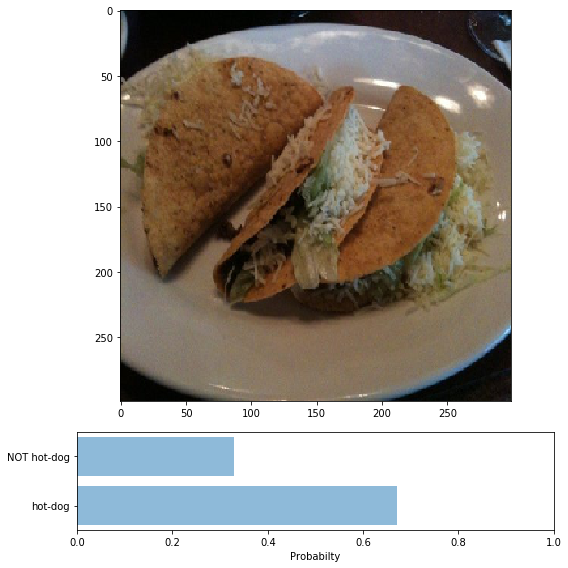

In [81]:
os.chdir("c:\\Lori\\Suil\\DA_3\\Hazi_2\\HDNHD\\hot-dog-not-hot-dog")

fnames = os.listdir('test/not_hot_dog')
sel_fname = fnames[45] #123
img = image.load_img('test/not_hot_dog/'+sel_fname, target_size=(299, 299))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)
preds

array([0.5984458, 0.4015542], dtype=float32)

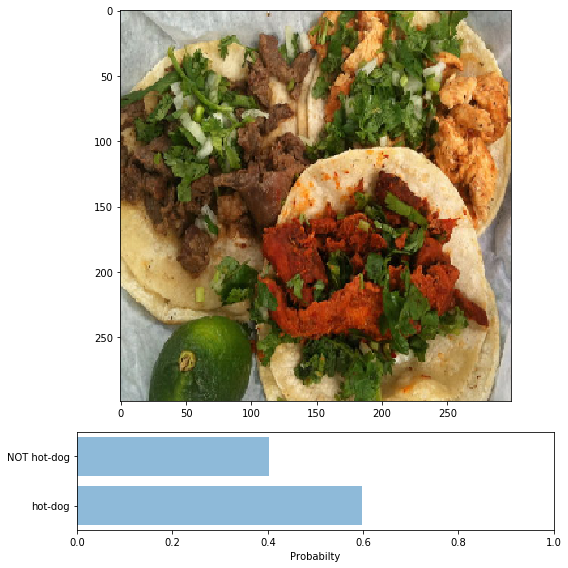

In [83]:
fnames = os.listdir('test/not_hot_dog')
sel_fname = fnames[123] #123
img = image.load_img('test/not_hot_dog/'+sel_fname, target_size=(299, 299))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)
preds

Well, as we can see in this case the model is less accurate. It seems that tortillas seem very similar to hot dogs for the model. 

### Final words ###

The ~91% validation accuracy seem quite acceptable to me. However in order to make the model more accurate there are plenty of possibilities. I am sure that with a little bit more aggressive data augmentation (rotation, width/height shift), bigger batch size, optimizer with adaptive learning rates, larger epoch siz the accuracy of the model could be incrased.